# Comparison with Oleh

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.transform
import skimage.morphology

from typing import List, Tuple
from typing import Optional
import numpy
from MODULES.namedtuple import Partition

### Helper functions

In [4]:
def contours_from_labels(labels, thickness: int=1):
    contours = (skimage.morphology.dilation(labels)  != labels)
    for i in range(1,thickness):
        contours = skimage.morphology.binary_dilation(contours)
    return contours


def add_red_contours(image, contours):
    assert image.shape[:2] == contours.shape[:2]
    my_max = numpy.max(image)
    if len(image.shape) == 2:
        image = numpy.repeat(image[..., None], 3, axis=-1)
    assert len(image.shape)== 3 # w,h,ch
    assert image.shape[-1] == 3 # 3 chgannels
    image[contours == 1, 0] = my_max
    image[contours == 1, 1:] = 0
    return image


def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    delta = 200
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        if (ROI_mask[iw,ih] == 0) and (ROI_mask[iw+crop_size,ih] == 0) and \
           (ROI_mask[iw,ih+crop_size] == 0) and (ROI_mask[iw+crop_size,ih+crop_size] == 0):
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window


def plot_comparison(raw_img, labels1, labels2, window: Optional[List[tuple]] = None, figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=2, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, thickness=3)
        c2 = contours_from_labels(l2, thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            

def make_and_save_segmentation(file_name, labels, raw_image):
    assert labels.shape[:2] == raw_image.shape[:2]
    c = contours_from_labels(labels=labels, thickness=3)
    tmp = add_red_contours(image=skimage.img_as_ubyte(raw_image), contours=c)
    print(tmp.shape, tmp.dtype)
    skimage.io.imsave(file_name, tmp)

### Open the files

In [15]:
image_file = "smFISH_stitched_OLEH.tif"
oleh_file = "smFISH-full_result_mask.tif"
luca_file = "segmentation_res800.tiff"

raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(image_file)))
#luca_img = skimage.io.imread(luca_file).astype(numpy.uint16)
#oleh_img = skimage.io.imread(oleh_file).astype(numpy.uint16)

In [6]:
luca_labels_OLD = skimage.morphology.label(luca_img, background=0, return_num=False).astype(numpy.uint16)
oleh_labels = skimage.morphology.label(oleh_img, background=0, return_num=False).astype(numpy.uint16)

print(raw_img.shape, raw_img.dtype)
print(luca_img.shape, luca_labels_OLD.dtype)
print(oleh_img.shape, oleh_labels.dtype)

(21505, 21505) uint8
(2688, 2688) uint16
(21505, 21505) uint16


### Upsample luca's labels to match size of Oleh's labels 

In [7]:
luca_labels = skimage.transform.resize(luca_labels_OLD, oleh_labels.shape,
                                       order=0, 
                                       clip=True, preserve_range=True).astype(numpy.uint16)
print(luca_labels.shape, luca_labels.dtype)

(21505, 21505) uint16


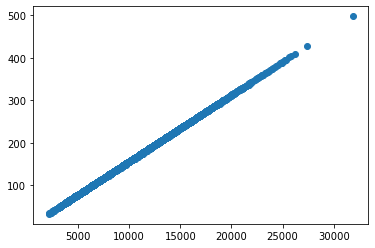

In [8]:
# Compute the areas and check nothing went worng during upsampling
luca_cells_area_OLD = numpy.bincount(luca_labels_OLD.flatten())[1:]
luca_cells_area = numpy.bincount(luca_labels.flatten())[1:]
oleh_cells_area = numpy.bincount(oleh_labels.flatten())[1:]

plt.scatter(luca_cells_area,luca_cells_area_OLD)

### Save both segmentation with red contours 

In [ ]:
# make_and_save_segmentation(file_name="tmp.tiff", 
#                            labels=luca_labels[10000:11000,10000:11000], 
#                            raw_image=raw_img[10000:11000,10000:11000])

In [ ]:
# make_and_save_segmentation(file_name="luca_segmentation.tiff", 
#                            labels=luca_labels, 
#                            raw_image=raw_img)

In [ ]:
# make_and_save_segmentation(file_name="oleh_segmentation.tiff", 
#                            labels=oleh_labels, 
#                            raw_image=raw_img)

# Start the actual comparison

Based on:
1. luca_labels vs oleh_labels
2. luca_cells_area vs oleh_cells_area 

In [11]:
ROI_mask = skimage.morphology.convex_hull_image(luca_labels > 0)
#plt.imshow(ROI_mask)

uint8 uint8
uint8 uint8
uint8 uint8
uint8 uint8


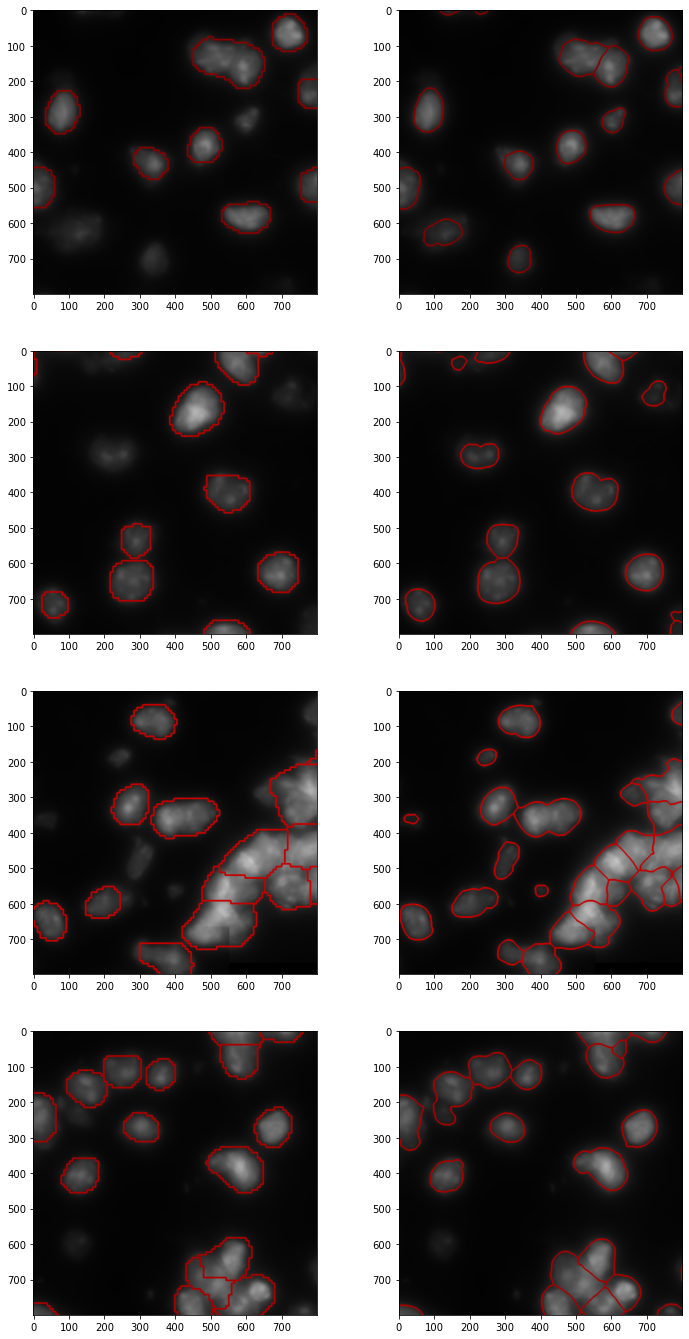

In [70]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(12,24))

In [ ]:
print("total segmented area: luca, oleh", luca_cells_area.sum(), oleh_cells_area.sum())

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel("cells area")
_ = ax.hist([luca_cells_area,oleh_cells_area], bins=50,label=["luca","oleh"])
_ = ax.legend()
fig.savefig("histo.png", dpi=300)

In [ ]:
float(luca_cells_area.shape[0]) / oleh_cells_area.shape[0]

In [ ]:
ratio_ol = float(oleh_cells_area.sum())/luca_cells_area.sum()
ratio_lo = float(luca_cells_area.sum())/oleh_cells_area.sum()
print(ratio_ol, ratio_lo)

In [ ]:
oleh_cells_area.sum()

In [ ]:
luca_cells_area.sum()

uint8 uint8


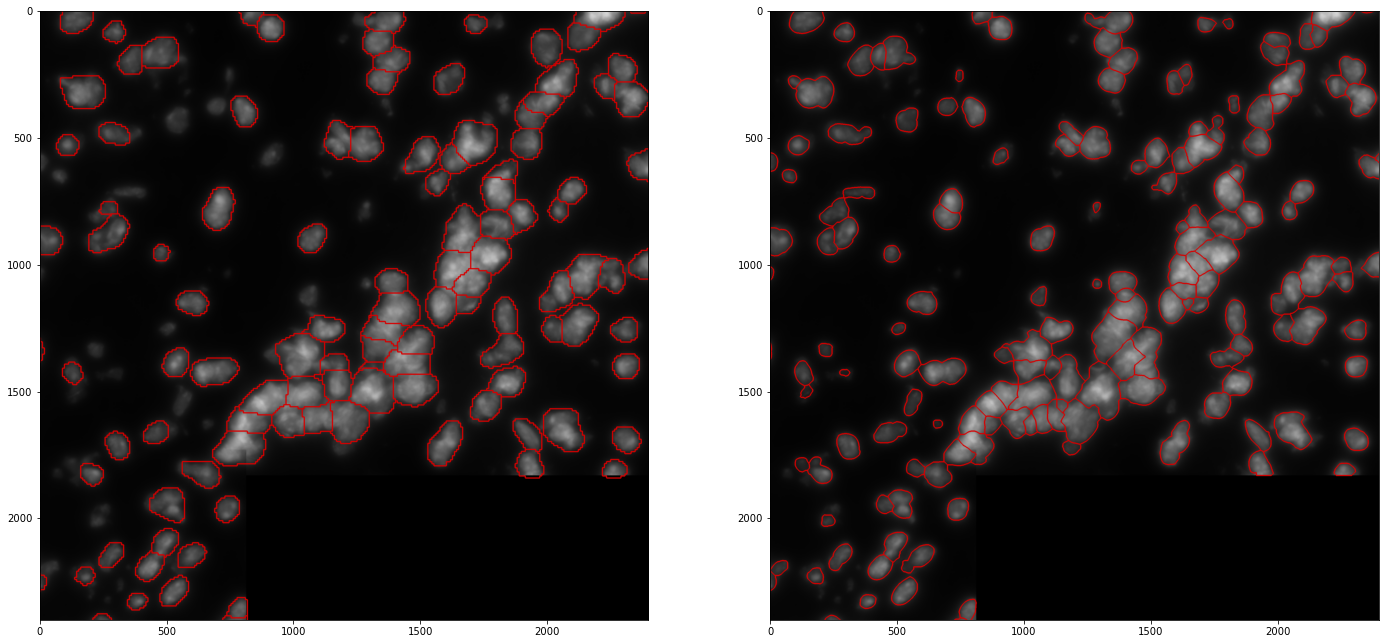

In [63]:
window = [(8*1000, 8*2100, 8*1300, 8*2400)]
#window = [(8*1000, 8*2100, 8*1100, 8*2200)]

plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(24,24))

### Compute intersection over union

In [60]:
import torch 
window = (8*1000, 8*2100, 8*1300, 8*2400)
window = (8*1000, 8*2100, 8*1100, 8*2200)
window = (0,0,luca_labels.shape[0],luca_labels.shape[1])

size = window[2]-window[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

luca_membership = torch.from_numpy(luca_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
oleh_membership = torch.from_numpy(oleh_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
luca_sizes = torch.bincount(luca_membership)
oleh_sizes = torch.bincount(oleh_membership)

In [61]:
sizes, membership = Partition.compactify(luca_sizes, luca_membership)
luca_partition = Partition(which="luca",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

sizes, membership = Partition.compactify(oleh_sizes, oleh_membership)
oleh_partition = Partition(which="oleh",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))

In [62]:
c = luca_partition.concordance_with_partition(oleh_partition) 

CELLS WITH UNIQUE MAPPING 4607


In [65]:
c.iou

0.6220703721046448

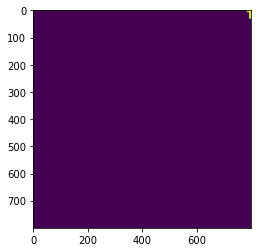

In [53]:
plt.imshow(luca_partition.membership.view(size,size)==1)

In [46]:
c

ConcordancePartition(joint_distribution=tensor([[8.1739e-01, 3.4844e-04, 3.4687e-04, 1.6234e-03, 1.5000e-03, 8.1406e-04,
         5.1844e-03, 1.3766e-03, 1.0781e-03, 1.6828e-03, 2.8141e-03, 1.0469e-04],
        [0.0000e+00, 0.0000e+00, 1.0937e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1250e-06, 1.0156e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.4063e-04, 0.0000e+00, 1.4742e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0625e-05, 0.0000e+00, 0.0000e+00, 7.0766e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.1078e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5298e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [34]:
torch.max(pxy)

tensor(0.8174)

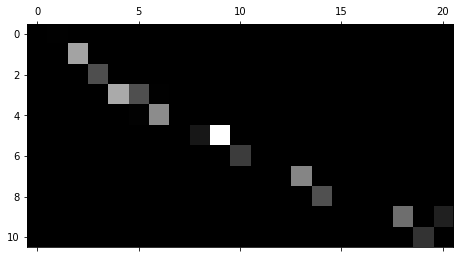

In [37]:
plt.matshow(pxy[1:,1:].T, cmap='gray')

In [ ]:
c_ol = oleh_partition.concordance_with_partition(luca_partition) 

In [ ]:
c_lo = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c_ol.iou

In [ ]:
c_lo.iou

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))